In [8]:
import pandas as pd


In [9]:
def feature_engineering(df_train):
    df_train['first_timestamp'] = pd.to_datetime(df_train['first_timestamp'])

    # day
    df_train['Day'] = df_train['first_timestamp'].dt.day
    # month
    df_train['Month'] = df_train['first_timestamp'].dt.month
    # hour
    df_train['Start_hour'] = df_train['first_timestamp'].dt.hour
    # minute
    df_train['Start_minute'] = df_train['first_timestamp'].dt.minute
    # second
    df_train['Start_second'] = df_train['first_timestamp'].dt.second
    # Monday is 0 and Sunday is 6
    df_train['Start_weekday'] = df_train['first_timestamp'].dt.weekday
    # week of the year
    df_train['Start_week_of_year'] = df_train['first_timestamp'].dt.week

    df_train.drop('first_timestamp', inplace=True, axis=1)

    return df_train

In [10]:
df_train = pd.read_csv('../../data/prefix_data/full_prefix_train.csv', index_col=0).fillna(0)
df_test = pd.read_csv('../../data/prefix_data/full_prefix_test.csv', index_col=0).fillna(0)

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)


X_train = df_train.drop(columns=['case_outcome'], inplace=False).reset_index(drop=True)
y_train = df_train['case_outcome'].reset_index(drop=True)

X_test = df_test.drop(columns=['case_outcome'], inplace=False).reset_index(drop=True)
y_test = df_test['case_outcome'].reset_index(drop=True)

/var/folders/9l/kwd1671542z9tyvsgbp6mmtr0000gn/T/ipykernel_9955/1275838501.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_train['Start_week_of_year'] = df_train['first_timestamp'].dt.week
/var/folders/9l/kwd1671542z9tyvsgbp6mmtr0000gn/T/ipykernel_9955/1275838501.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_train['Start_week_of_year'] = df_train['first_timestamp'].dt.week


In [11]:
col_dict = {}
dtypes_list = dict(df_train.dtypes)
for pair in dtypes_list.items():
    key = str(pair[1])
    col_dict[key] = col_dict.get(key, []) + [pair[0]]

col_dict["object"].pop()
col_dict['object']

['Accepted', 'Selected', 'case:LoanGoal', 'case:ApplicationType']

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import accuracy_score
import numpy as np

In [13]:
categorical_pipe = make_pipeline(OneHotEncoder())
numeric_pipe = make_pipeline(StandardScaler())

# Using categorical pipe for features A,B,C, numeric pipe otherwise
preprocessor = make_column_transformer((categorical_pipe, col_dict['object']), remainder=numeric_pipe)

# Combine with learning algorithm in another pipeline

pipe = make_pipeline(preprocessor, SGDClassifier(n_jobs=-1))
# multi_class = 'ovr')
pipe.named_steps

{'columntransformer': ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                              StandardScaler())]),
                   transformers=[('pipeline',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder())]),
                                  ['Accepted', 'Selected', 'case:LoanGoal',
                                   'case:ApplicationType'])]),
 'sgdclassifier': SGDClassifier(n_jobs=-1)}

In [14]:
pipe.fit(X_train.drop(columns=['case_progression']), y_train)
y_pred = pipe.predict(X_test)
score = accuracy_score(y_pred=y_pred, y_true=y_test)
score

0.7740272789862489

In [21]:
alphas = 2 ** np.arange(-15.0, 15, 2)
losses = ['hinge', 'log_loss']
gridsearch_dict = {}

for alpha in alphas:
        print(alpha)
        for loss in losses:
                print(loss)
                pipe.set_params(sgdclassifier__loss = loss, sgdclassifier__alpha = alpha)
                pipe.fit(X_train.drop(columns=['case_progression']), y_train)
                y_pred = pipe.predict(X_test.drop(columns=['case_progression']))
                score = accuracy_score(y_pred=y_pred, y_true=y_test)
                gridsearch_dict[(loss, alpha)] = score




3.0517578125e-05
hinge
log_loss
0.0001220703125
hinge
log_loss
0.00048828125
hinge
log_loss
0.001953125
hinge
log_loss
0.0078125
hinge
log_loss
0.03125
hinge
log_loss
0.125
hinge
log_loss
0.5
hinge
log_loss
2.0
hinge
log_loss
8.0
hinge
log_loss
32.0
hinge
log_loss
128.0
hinge
log_loss
512.0
hinge
log_loss
2048.0
hinge
log_loss
8192.0
hinge
log_loss


In [22]:
print('sgdclassifier')
print("best parameters were " , max(gridsearch_dict, key=gridsearch_dict.get), ' with an accuracy of ', max(gridsearch_dict.values()))

sgdclassifier
best parameters were  ('hinge', 0.0078125)  with an accuracy of  0.7818611488435273


# Seeing the effect of case progression

In [23]:
def bucketed_testing(pipe, X_train, y_train, X_test, y_test, progression):
    X_train = X_train[X_train['case_progression'] <= progression].drop(columns=['case_progression'])
    y_train = y_train[y_train.index.isin(X_train.index)]
    
    X_test = X_test[X_test['case_progression'] <= progression].drop(columns=['case_progression'])
    y_test = y_test[y_test.index.isin(X_test.index)]


    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    score = accuracy_score(y_pred=y_pred, y_true=y_test)

    return score

In [25]:
import numpy as np

pipe.set_params(sgdclassifier__loss = 'hinge', sgdclassifier__alpha = 0.0078125)
prog = np.arange(0.0, 1, 0.05)

# store the results for different min_sim
res_prog = {}
for n in prog:

    res_prog[n] = bucketed_testing(pipe, X_train, y_train, X_test, y_test, n)


<AxesSubplot: xlabel='case_progression', ylabel='accuracy'>

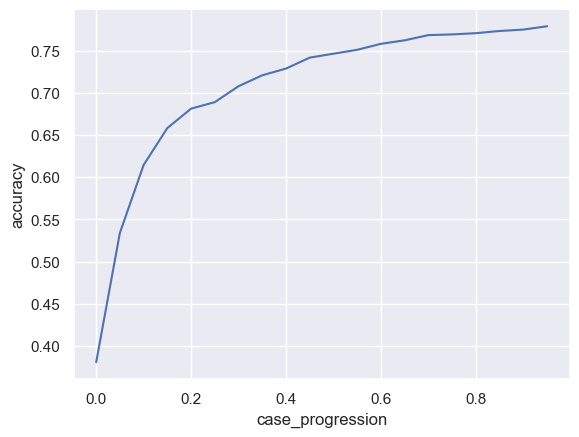

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

df_progression_results = pd.DataFrame.from_dict(res_prog, orient='index').reset_index().rename(
    columns={"index": "case_progression", 0: "accuracy"})

sns.lineplot(
    data=df_progression_results,
    x="case_progression", y="accuracy", markers=True, dashes=False
)